In [48]:
import os
import torch
import librosa
import numpy as np
import pandas as pd
from panns_inference import AudioTagging

# # --- CONFIG ---
# AUDIO_DIR = r"D:\DEAM_audio_wav"
# EMB_DIR   = r"C:\Users\Ashutosh Gupta\OneDrive\문서\emotion_recognition_research\data\PANN_Embeedings"
# os.makedirs(EMB_DIR, exist_ok=True)

# # --- Setup Model ---
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# at = AudioTagging(checkpoint_path=None, device=device)

# # --- Extract Loop ---
# for fname in os.listdir(AUDIO_DIR):
#     if not fname.endswith('.wav'): continue
#     path = os.path.join(AUDIO_DIR, fname)
#     song_id = os.path.splitext(fname)[0]

#     # load audio
#     y, sr = librosa.load(path, sr=32000, mono=True, duration=3)
#     if len(y) < 3 * sr:
#         y = np.pad(y, (0, 3*sr - len(y)))

#     x = torch.tensor(y[None, :], dtype=torch.float32, device=device)

#     # inference
#     clipwise_output, embedding = at.inference(x)  # embedding shape: (1, 2048)

#     emb = embedding.squeeze()
#     np.save(os.path.join(EMB_DIR, song_id + '.npy'), emb)


In [39]:
df_a=pd.read_csv(r"C:\Users\Ashutosh Gupta\OneDrive\문서\emotion_recognition_research\data\DEAM_Annotations\annotations\annotations averaged per song\dynamic (per second annotations)\arousal.csv")
df_v=pd.read_csv(r"C:\Users\Ashutosh Gupta\OneDrive\문서\emotion_recognition_research\data\DEAM_Annotations\annotations\annotations averaged per song\dynamic (per second annotations)\valence.csv")
cutoff_index = 1744
df_a = df_a.iloc[:cutoff_index]
df_v = df_v.iloc[:cutoff_index]

In [40]:
all_rows = []

for song_id in df_a['song_id']:
    # --- Arousal ---
    ar = df_a[df_a['song_id'] == song_id].drop(columns='song_id').T
    ar.index = ar.index.str.extract(r'(\d+)').astype(int).squeeze()
    ar = ar.sort_index()
    df_ar = pd.DataFrame({
        'time_sec': ar.index.values / 1000,
        'arousal_value': ar.values.squeeze()
    })

    # --- Valence ---
    va = df_v[df_v['song_id'] == song_id].drop(columns='song_id').T
    va.index = va.index.str.extract(r'(\d+)').astype(int).squeeze()
    va = va.sort_index()
    df_va = pd.DataFrame({
        'time_sec': va.index.values / 1000,
        'valence_value': va.values.squeeze()
    })

    # --- Merge ---
    df_song = pd.merge(df_ar, df_va, on='time_sec', how='inner')
    df_song = df_song[(df_song['time_sec'] >= 15.0) & (df_song['time_sec'] <= 60.0)]
    df_song[['valence_value', 'arousal_value']] = df_song[['valence_value', 'arousal_value']].interpolate()

    df_song['song_id'] = song_id
    all_rows.append(df_song)

# Concatenate all
df_all = pd.concat(all_rows).reset_index(drop=True)

In [41]:
df_all

,time_sec,arousal_value,valence_value,song_id
0,15.0,-0.109386,-0.073341,2
1,15.5,-0.114942,-0.074661,2
2,16.0,-0.116413,-0.074077,2
3,16.5,-0.118613,-0.078154,2
4,17.0,-0.126457,-0.081588,2
...,...,...,...,...
158699,58.0,0.478000,0.424000,2000
158700,58.5,0.478000,0.424000,2000
158701,59.0,0.478000,0.424000,2000
158702,59.5,0.478000,0.424000,2000


In [42]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- Parameters ---
CHUNK_DURATION = 3.0  # seconds
STEP = 0.5  # resolution of df_all

# --- Input Data ---
# df_all = ... (already loaded)
# Assuming df_all has: ['time_sec', 'arousal_value', 'valence_value', 'song_id']

# --- Build target values aligned to 3-sec chunks ---
aligned_rows = []

for song_id in df_all['song_id'].unique():
    song_df = df_all[df_all['song_id'] == song_id].sort_values('time_sec')

    song_duration = song_df['time_sec'].max()
    n_chunks = int(np.floor(song_duration / CHUNK_DURATION))

    for chunk_id in range(n_chunks):
        start = chunk_id * CHUNK_DURATION
        end = start + CHUNK_DURATION

        # Select rows in this chunk range
        chunk_rows = song_df[(song_df['time_sec'] >= start) & (song_df['time_sec'] < end)]

        if len(chunk_rows) == 0:
            continue  # skip empty

        mean_val = chunk_rows['valence_value'].mean()
        mean_ar = chunk_rows['arousal_value'].mean()

        aligned_rows.append({
            'song_id': song_id,
            'chunk_id': chunk_id,
            'valence': mean_val,
            'arousal': mean_ar
        })

df_targets = pd.DataFrame(aligned_rows)
print(f"✅ Aligned target shape: {df_targets.shape}")
df_targets.head()

✅ Aligned target shape: (26160, 4)


,song_id,chunk_id,valence,arousal
0,2,5,-0.077115,-0.119835
1,2,6,-0.083926,-0.139542
2,2,7,-0.090655,-0.151573
3,2,8,-0.154833,-0.143460
4,2,9,-0.225280,-0.157012


In [43]:
import os
import numpy as np
import pandas as pd
import pickle

df_songlevel = df_targets.groupby('song_id')[['valence', 'arousal']].mean().reset_index()

# --- Path to embeddings ---
EMB_DIR = r"C:\Users\Ashutosh Gupta\OneDrive\문서\emotion_recognition_research\data\PANN_Embeedings"

data = []

for _, row in df_songlevel.iterrows():
    song_id = int(row['song_id'])
    filename = f"{song_id}.npy"  # Since your files are named like 2.npy, 3.npy
    emb_path = os.path.join(EMB_DIR, filename)

    if os.path.exists(emb_path):
        emb = np.load(emb_path)
        data.append({
            'embedding': emb,
            'valence': row['valence'],
            'arousal': row['arousal']
        })
    else:
        print(f"⚠️ Missing: {filename}")

# Save the aligned dataset
with open("panns_songlevel_dataset.pkl", "wb") as f:
    pickle.dump(data, f)

print(f"✅ Final aligned dataset size: {len(data)} songs")


✅ Final aligned dataset size: 1744 songs


In [44]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np

# Load the aligned dataset
with open("panns_songlevel_dataset.pkl", "rb") as f:
    data = pickle.load(f)

# Dataset class
class SongLevelDataset(Dataset):
    def __init__(self, data):
        self.embeddings = [d['embedding'] for d in data]
        self.valence = [d['valence'] for d in data]
        self.arousal = [d['arousal'] for d in data]

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        val = torch.tensor(self.valence[idx], dtype=torch.float32)
        aro = torch.tensor(self.arousal[idx], dtype=torch.float32)
        return emb, val, aro

# Train/Val Split
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = SongLevelDataset(train_data)
val_dataset = SongLevelDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

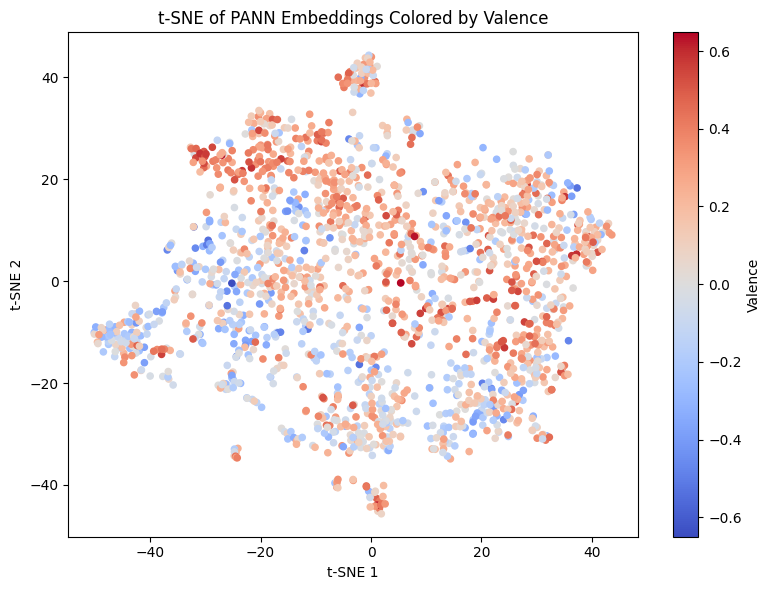

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = np.array([d['embedding'] for d in data])
valence = np.array([d['valence'] for d in data])
X_emb = TSNE(n_components=2, perplexity=30).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=valence, cmap='coolwarm', s=20)
plt.colorbar(label='Valence')
plt.title("t-SNE of PANN Embeddings Colored by Valence")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()


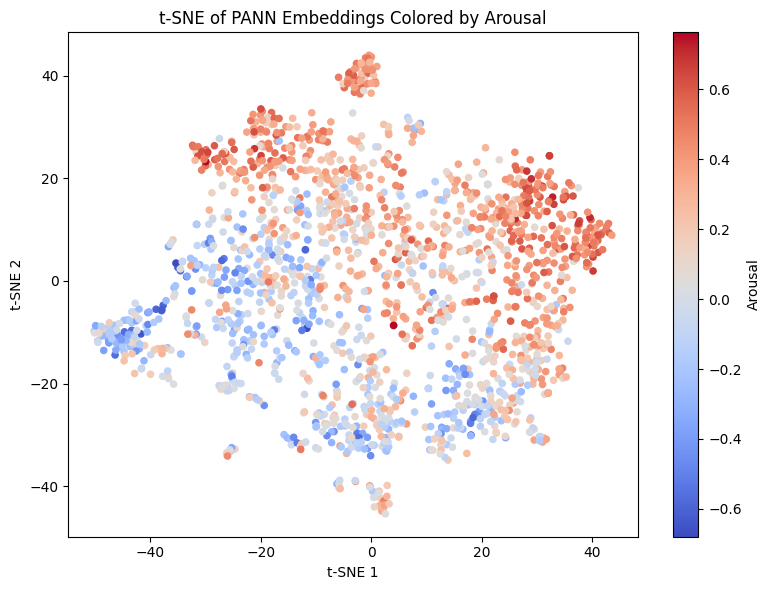

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = np.array([d['embedding'] for d in data])
valence = np.array([d['arousal'] for d in data])
X_emb = TSNE(n_components=2, perplexity=30).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=valence, cmap='coolwarm', s=20)
plt.colorbar(label='Arousal')
plt.title("t-SNE of PANN Embeddings Colored by Arousal")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()


In [45]:
import torch.nn as nn

class EmotionMLP(nn.Module):
    def __init__(self, input_dim=2048):
        super(EmotionMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Output: [valence, arousal]
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import torch.optim as optim
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionMLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for emb, val, aro in train_loader:
        emb, val, aro = emb.to(device), val.to(device), aro.to(device)
        optimizer.zero_grad()
        outputs = model(emb)
        loss = criterion(outputs[:, 0], val) + criterion(outputs[:, 1], aro)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * emb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for emb, val, aro in val_loader:
            emb = emb.to(device)
            outputs = model(emb).cpu().numpy()
            targets = torch.stack((val, aro), dim=1).numpy()
            preds.append(outputs)
            trues.append(targets)

    preds = np.vstack(preds)
    trues = np.vstack(trues)

    r2_val = r2_score(trues[:, 0], preds[:, 0])
    r2_aro = r2_score(trues[:, 1], preds[:, 1])
    rmse_val = mean_squared_error(trues[:, 0], preds[:, 0]) ** 0.5
    rmse_aro = mean_squared_error(trues[:, 1], preds[:, 1]) ** 0.5
    mae_val = mean_absolute_error(trues[:, 0], preds[:, 0])
    mae_aro = mean_absolute_error(trues[:, 1], preds[:, 1])

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f} | "
          f"R2 Valence: {r2_val:.4f} | R2 Arousal: {r2_aro:.4f} | "
          f"RMSE Valence: {rmse_val:.4f} | RMSE Arousal: {rmse_aro:.4f} | "
          f"MAE Valence: {mae_val:.4f} | MAE Arousal: {mae_aro:.4f}")


Epoch 1/30 - Loss: 0.0859 | R2 Valence: 0.4132 | R2 Arousal: 0.6592 | RMSE Valence: 0.1750 | RMSE Arousal: 0.1659 | MAE Valence: 0.1423 | MAE Arousal: 0.1283
Epoch 2/30 - Loss: 0.0626 | R2 Valence: 0.4303 | R2 Arousal: 0.6523 | RMSE Valence: 0.1724 | RMSE Arousal: 0.1676 | MAE Valence: 0.1385 | MAE Arousal: 0.1325
Epoch 3/30 - Loss: 0.0575 | R2 Valence: 0.4509 | R2 Arousal: 0.6670 | RMSE Valence: 0.1693 | RMSE Arousal: 0.1640 | MAE Valence: 0.1361 | MAE Arousal: 0.1274
Epoch 4/30 - Loss: 0.0551 | R2 Valence: 0.2587 | R2 Arousal: 0.6379 | RMSE Valence: 0.1967 | RMSE Arousal: 0.1710 | MAE Valence: 0.1567 | MAE Arousal: 0.1372
Epoch 5/30 - Loss: 0.0540 | R2 Valence: 0.4365 | R2 Arousal: 0.6671 | RMSE Valence: 0.1715 | RMSE Arousal: 0.1640 | MAE Valence: 0.1353 | MAE Arousal: 0.1268
Epoch 6/30 - Loss: 0.0505 | R2 Valence: 0.4407 | R2 Arousal: 0.6609 | RMSE Valence: 0.1709 | RMSE Arousal: 0.1655 | MAE Valence: 0.1368 | MAE Arousal: 0.1270
Epoch 7/30 - Loss: 0.0483 | R2 Valence: 0.4130 | R2 